## Speedtest for torch and numpy

This notebook is a simple speedtest to investigate what produces the runtime overhead in PyTorch optimizations on a real triplet dataset. 

This was suggested by Scott Sievert during the JOSS review. Parts of the code base on his suggestions:
https://github.com/openjournals/joss-reviews/issues/6139#issuecomment-1982282601    

In [1]:
import torch
import time
import scipy.optimize
import numpy as np
from typing import Tuple
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.spatial import distance

from cblearn.embedding._torch_utils import assert_torch_is_available, torch_minimize
from datasets import fetch_dataset

sns.set_theme("paper", "whitegrid", font_scale=1.5)
plot_dir = Path('../plots')
data_dir = Path('../results')
plot_dir.mkdir(exist_ok=True)


def pytorch_grad(f):
    def get_grad(x, *args):
        y = torch.from_numpy(x)
        y.requires_grad = True
        args = list(args)
        for i, a in enumerate(args):
            if isinstance(a, np.ndarray):
                args[i] = torch.from_numpy(a)
        loss = f(y, *args)
        loss.backward()
        grad = y.grad
        return loss, grad  #.ravel()
    return get_grad


def f_torch(X, triplets, mu, float_min=np.finfo(float).tiny):
    """
    This function is based on the torch CKL loss in cblearn, modified by Scott Sievert.
    https://github.com/cblearn/cblearn/blob/eecf85f9fde0bf264041a323623b630dbdfd5aa2/cblearn/embedding/_ckl.py#L143-L153
    """
    # Perform the expansion of (x - y)**2 = x@x + y@y - 2x@y w/ broadcasting
    # (more easily allows the gradient to be tracked)
    _Dxy = X @ X.T
    _Dx = (X**2).sum(axis=1).reshape(1, -1)
    _Dy = (X**2).sum(axis=1).reshape(-1, 1)
    D = _Dx + _Dy - 2*_Dxy

    I, J, K = tuple(triplets.T)
    nom = mu + D[I, K]
    den = 2 * mu + D[I, K] + D[I, J]
    loss = -(torch.log(nom + float_min) - torch.log(den + float_min)).sum()
    return loss

def f_numpy_internaltorch(x: np.ndarray, x_shape, triplets, mu, float_min=np.finfo(float).tiny):
    x = x.reshape(x_shape)
    loss, grad = pytorch_grad(f_torch)(x, triplets, mu, float_min)
    return loss.item(), grad.detach().numpy().ravel()

def f_numpy(x: np.ndarray, x_shape, triplets, mu, float_min=np.finfo(float).tiny):
    """
    This function is based on the numpy CKL loss in cblearn
    https://github.com/cblearn/cblearn/blob/eecf85f9fde0bf264041a323623b630dbdfd5aa2/cblearn/embedding/_ckl.py#L143-L153
    """
    X = x.reshape(x_shape)
    n_objects, n_dim = X.shape
    D = distance.squareform(distance.pdist(X, 'sqeuclidean'))
    I, J, K = tuple(triplets.T)
    nom = mu + D[I, K]
    den = 2 * mu + D[I, K] + D[I, J]
    loss = -(np.log(np.maximum(nom, float_min)) - np.log(np.maximum(den, float_min))).sum()

    loss_grad = np.empty_like(X)
    for dim in range(n_dim):
        triplet_grads = [
            2 / nom * (X[I, dim] - X[K, dim]) - 2 / den * ((X[I, dim] - X[J, dim]) + (X[I, dim] - X[K, dim])),
            2 / den * (X[I, dim] - X[J, dim]),
            -2 / nom * (X[I, dim] - X[K, dim]) + 2 / den * (X[I, dim] - X[K, dim]),
            ]
        loss_grad[:, dim] = -np.bincount(triplets[:, 0], triplet_grads[0], n_objects)
        loss_grad[:, dim] -= np.bincount(triplets[:, 1], triplet_grads[1], n_objects)
        loss_grad[:, dim] -= np.bincount(triplets[:, 2], triplet_grads[2], n_objects)

    return loss, loss_grad.ravel()


def optimize(optim, f, lr=0.1, max_iter=1000, *args):
    x0 = np.random.normal(size=(N_OBJECTS, DIM))
    triplets = TRIPLETS
    mu = 0

    if optim == 'scipy':
        result = scipy.optimize.minimize(
            f,
            x0=x0.ravel(),
            args=(x0.shape, triplets, mu),
            jac=True,
            method="L-BFGS-B",
        )
    elif optim == 'torch':
        result = torch_minimize('adam', f, x0, data=(triplets, ), args=(mu,),
                                device='CPU', max_iter=max_iter, lr=lr)

    if not result.success:
        print(f"optimization failed: {result.message}.\n")
    x_result = result.x.reshape(x0.shape)

    norm = np.linalg.norm
    i, j, k = triplets.T
    error = (norm(x_result[i] - x_result[j], ord=2, axis=1)
             > norm(x_result[i] - x_result[k], ord=2, axis=1)).mean()
    return error


def measure_time(n_repeat: int, func, **args):
    timings = []
    responses = []
    for _ in range(n_repeat):
        start_time = time.process_time()
        resp = func(**args)
        end_time = time.process_time()
        timings.append(end_time - start_time)
        responses.append(resp)

    return timings, responses

DATASET = fetch_dataset("vogue")
TRIPLETS = np.asarray(DATASET['train_triplets'])
N_OBJECTS = DATASET['n_objects']
DIM = 2
n = 20
total_df = pd.DataFrame()
np.random.seed(42)

def fit_cblearn_CKL():
    from cblearn import embedding
    model = embedding.CKL(2)
    model.fit(TRIPLETS)
    return 1 - model.score(TRIPLETS)

file_name = data_dir / 'torch_triplet_speedtest.pkl'
if file_name.exists():
    total_df = pd.read_pickle(file_name)
else:
    times, responses = measure_time(n, fit_cblearn_CKL)
    df = pd.DataFrame({"time": times, "error": responses, "method": "cblearn"})
    total_df = pd.concat([total_df, df])

    times, responses = measure_time(n, optimize, optim='scipy', f=f_numpy)
    df = pd.DataFrame({"time": times, "error": responses, "method": "scipy"})
    total_df = pd.concat([total_df, df])

    times, responses = measure_time(n, optimize, optim='scipy', f=f_numpy_internaltorch)
    df = pd.DataFrame({"time": times, "error": responses, "method": "scipy+autograd"})
    total_df = pd.concat([total_df, df])

    times, responses = measure_time(n, optimize, optim='torch', f=f_torch, lr=10)
    df = pd.DataFrame({"time": times, "error": responses, "method": "torch"})
    total_df = pd.concat([total_df, df])
    total_df.to_pickle(file_name)


print(total_df)

/tmp/ipykernel_37893/1882033098.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

         time     error   method
0    0.419866  0.208672  cblearn
1    0.251396 

                     time     error    rel_time
method                                         
cblearn          0.256698  0.218767    1.183225
scipy            0.216948  0.216960    1.000000
scipy+autograd   1.798974  0.220325    8.292206
torch           46.725835  0.222809  215.378423


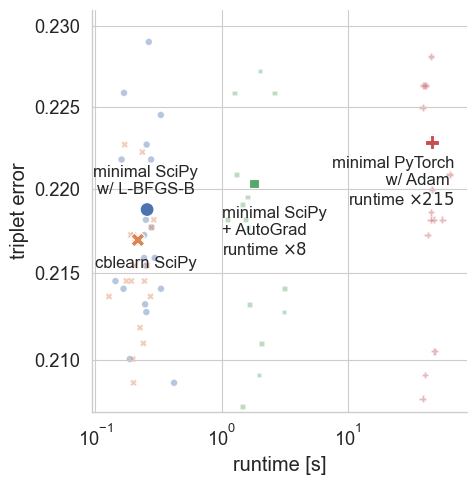

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

print(total_df.groupby('method').mean())
total_df['rel_time'] = total_df['time'] / total_df[total_df.method=='scipy']['time'].mean()
mean_df = total_df.groupby('method').mean().reset_index()
autograd_cost = mean_df[mean_df.method=='scipy+autograd']['time'].item() / mean_df[mean_df.method=='scipy']['time'].item()
torch_cost = mean_df[mean_df.method=='torch']['time'].item() / mean_df[mean_df.method=='scipy']['time'].item()
cbl_cost = mean_df[mean_df.method=='cblearn']['time'].item() / mean_df[mean_df.method=='scipy']['time'].item()
p = sns.relplot(kind="scatter", data=mean_df, x="time", y="error",
                hue="method", style='method',
                s=100, legend=False)
sns.scatterplot(data=total_df, x="time", y="error", hue="method", style='method',
                legend=False, alpha=0.4, zorder=0)
plt.text(.25, 0.2195, "minimal SciPy\nw/ L-BFGS-B", fontsize=12, ha='center', va='bottom')
plt.text(.25, 0.216, "cblearn SciPy",
          fontsize=12, ha='center', va='top')
plt.text(1., 0.219, "minimal SciPy\n+ AutoGrad\n"
         f"runtime $\\times {autograd_cost:.0f}$", fontsize=12, ha='left', va='top')
plt.text(70, 0.222, "minimal PyTorch\n w/ Adam \n"
         f"runtime $\\times {torch_cost:.0f}$", fontsize=12, ha='right', va='top')

plt.xscale('log', base=10)
#p.ax.ticklabel_format(style='plain')
plt.yscale('log')
plt.ylim(0.207, 0.231)
p.set(yticks=[0.210, 0.215, 0.220, 0.225, 0.230], yticklabels=['0.210', '0.215', '0.220', '0.225', '0.230'],
      xlabel="runtime [s]", ylabel="triplet error")
plt.savefig(plot_dir / 'torch_speedtest_triplets.pdf', bbox_inches='tight')
plt.savefig(plot_dir / 'torch_speedtest_triplets.png', bbox_inches='tight')

## Hyperparameters

The performance of the adam optimizer depends largely on the learning rate.
We will therefore test different learning rates to choose the best one, to ensure a fair comparison.

In [19]:
n = 5
np.random.seed(42)

file_name = data_dir / 'torch_triplet_speedtest_lrsearch.pkl'
if file_name.exists():
    lr_df = pd.read_pickle(file_name)
else:
    lr_df = pd.DataFrame()
    for lr in (0.0001, 0.001, 0.01, 0.1, 1, 10, 100):
        print(lr)
        times, responses = measure_time(n, optimize, optim='torch', f=f_torch, lr=lr)
        df = pd.DataFrame({"time": times, "error": responses, "lr": lr})
        lr_df = pd.concat([lr_df, df])
    lr_df.to_pickle(file_name)

lr_df

0.0001
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

0.001
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

0.01
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

0.1
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimization failed: adam did not converge..

1
optimization failed: adam did not converge..

optimization failed: adam did not converge..

optimizati

,time,error,lr
0,38.773676,0.467028,0.0001
1,35.523806,0.481030,0.0001
2,41.079925,0.473803,0.0001
3,40.311762,0.527100,0.0001
4,40.730386,0.517164,0.0001
0,44.341040,0.322042,0.0010
1,45.198061,0.302168,0.0010
2,47.918193,0.343270,0.0010
3,41.373468,0.308040,0.0010
4,41.416149,0.337398,0.0010


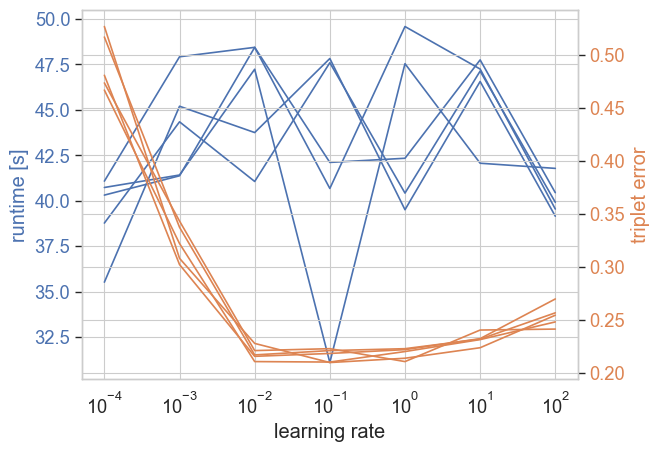

In [20]:
# time and error should both be on the y-axis
# therefore create a long dataframe with a value column, containing either time or error
#lr_df_2 = pd.melt(lr_df, id_vars=['lr'], value_vars=['time', 'error'], var_name='metric', value_name='value')
if 'index' not in lr_df.columns:
    lr_df = lr_df.reset_index()
fig, ax1 = plt.subplots()


ax1.set_xlabel('learning rate')
ax1.set_ylabel('runtime [s]', color = 'C0')
#ax1.plot(lr_df['lr'], lr_df['time'], color = 'C0')
sns.lineplot(data=lr_df, x='lr', y='time', color='C0', ax=ax1, errorbar=None, estimator=None,
             units='index')
ax1.tick_params(axis ='y', labelcolor = 'C0')
[t.set_color('C0') for t in ax1.yaxis.get_ticklines()]
[t.set_color('C0') for t in ax1.yaxis.get_ticklabels()]
# Adding Twin Axes

ax2 = ax1.twinx()
ax1.set_xscale('log')
ax2.set_xscale('log')
#ax2.set_yscale('log')

ax2.set_ylabel('triplet error', color = 'C1')
#ax2.plot(lr_df['lr'], lr_df['error'], color = 'C1')
sns.lineplot(data=lr_df, x='lr', y='error', color='C1', ax=ax2, units='index',errorbar=None, estimator=None)
#ax2.set_yticks([0.3, 0.4])
#ax2.set_yticklabels(['0.3', '0.4'])
#from matplotlib.ticker import ScalarFormatter
#ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.tick_params(axis ='y', labelcolor = 'C1')

# Show plot

plt.savefig(plot_dir / 'adam_lr_triplet.pdf', bbox_inches='tight')
plt.savefig(plot_dir / 'adam_lr_triplet.png', bbox_inches='tight')